![](https://i.imgur.com/j5zjnsn.png)

# About this notebook 📝

Image normalization is one of the crucial thing to do in computer vision tasks. This notebook is rather a very small one that will give an short summary on different datasets. 

# 1) Login to AIcrowd 🤩

In [4]:
#@title Login to AIcrowd
!pip install -U aicrowd-cli > /dev/null
!aicrowd login 2> /dev/null

Please login here: https://api.aicrowd.com/auth/zo-wY53l5nP45gOH4OlcrGquu0Axok4c22AdzkgTWac
API Key valid
Gitlab access token valid
Saved details successfully!


# 2) Setup magically, run the below cell 😉

In [5]:
#@title Magic Box ⬛ { vertical-output: true, display-mode: "form" }
try:
  import os
  if first_run and os.path.exists("/content/data-purchasing-challenge-2022-starter-kit/data/training"):
    first_run = False
except:
  first_run = True

if first_run:
  %cd /content/
  !git clone http://gitlab.aicrowd.com/zew/data-purchasing-challenge-2022-starter-kit.git > /dev/null
  %cd data-purchasing-challenge-2022-starter-kit
  !aicrowd dataset list -c data-purchasing-challenge-2022
  !aicrowd dataset download -c data-purchasing-challenge-2022
  !mkdir -p data/
  !mv *.tar.gz data/ && cd data && echo "Extracting dataset" && ls *.tar.gz | xargs -n1 -I{} bash -c "tar -xvf {} > /dev/null"


def run_pre_training_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.pre_training_phase(self=run, training_dataset=training_dataset)
  # NOTE:It is critical that the checkpointing works in a self-contained way
  #      As, the evaluators might choose to run the different phases separately.
  run.save_checkpoint("/tmp/pretrainig_phase_checkpoint.pickle")

def run_purchase_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.purchase_phase = purchase_phase
  run.load_checkpoint("/tmp/pretrainig_phase_checkpoint.pickle")
  # Hacky way to make it work in notebook
  unlabelled_dataset.purchases = set()
  run.purchase_phase(self=run, unlabelled_dataset=unlabelled_dataset, training_dataset=training_dataset, budget=3000)
  run.save_checkpoint("/tmp/purchase_phase_checkpoint.pickle")
  del run

def run_prediction_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.purchase_phase = purchase_phase
  run.prediction_phase = prediction_phase
  run.load_checkpoint("/tmp/purchase_phase_checkpoint.pickle")
  run.prediction_phase(self=run, test_dataset=val_dataset)
  del run

/content
fatal: destination path 'data-purchasing-challenge-2022-starter-kit' already exists and is not an empty directory.
/content/data-purchasing-challenge-2022-starter-kit
                 Datasets for challenge #1024                                   
┌───┬───────────────────┬──────────────────────────┬─────────┐                  
│ # │ Title             │ Description              │    Size │                  
├───┼───────────────────┼──────────────────────────┼─────────┤                  
│ 0 │ validation.tar.gz │ Validation dataset       │ 182 MiB │                  
│ 1 │ unlabelled.tar.gz │ Unlabelled image dataset │ 609 MiB │                  
│ 2 │ training.tar.gz   │ Training data            │ 304 MiB │                  
│ 3 │ debug.tar.gz      │ Debug dataset            │ 6.1 MiB │                  
└───┴───────────────────┴──────────────────────────┴─────────┘                  
validation.tar.gz: 100% 191M/191M [00:09<00:00, 19.6MB/s]
unlabelled.tar.gz: 100% 638M/638M [00

# 3) Load datasets

In [6]:
from evaluator.dataset import ZEWDPCBaseDataset, ZEWDPCProtectedDataset
DATASET_SHUFFLE_SEED = 1022022

# Instantiate Training Dataset
training_dataset = ZEWDPCBaseDataset(
    images_dir="./data/training/images",
    labels_path="./data/training/labels.csv",
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# Instantiate Unlabelled Dataset
unlabelled_dataset = ZEWDPCProtectedDataset(
    images_dir="./data/unlabelled/images",
    labels_path="./data/unlabelled/labels.csv",
    budget=3000,  # Configurable Parameter
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# Instantiate Validation Dataset
val_dataset = ZEWDPCBaseDataset(
    images_dir="./data/validation/images",
    labels_path="./data/validation/labels.csv",
    drop_labels=True,
    shuffle_seed=DATASET_SHUFFLE_SEED,
)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def show_dataset_summary(dataset):
    images = []
    for sample in dataset:
        images.append(sample['image'])

    images = np.array(images)
    r_dim = images[:,:,:,0].ravel()
    g_dim = images[:,:,:,1].ravel()
    b_dim = images[:,:,:,2].ravel()

    print("Dataset shape: ", images.shape)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.tight_layout()
    ax[0].hist(r_dim, bins=50, density=True)
    ax[0].set_title("Red pixels distribution. \n Min={}, Max={}, Mean={:.2f}, Std={:.2f}".format(r_dim.min(), r_dim.max(), r_dim.mean(), r_dim.std()))
    ax[1].hist(g_dim, bins=50, density=True)
    ax[1].set_title("Green pixels distribution. \n Min={}, Max={}, Mean={:.2f}, Std={:.2f}".format(g_dim.min(), g_dim.max(), g_dim.mean(), g_dim.std()))
    ax[2].hist(b_dim, bins=50, density=True)
    ax[2].set_title("Blue pixels distribution. \n Min={}, Max={}, Mean={:.2f}, Std={:.2f}".format(b_dim.min(), b_dim.max(), b_dim.mean(), b_dim.std()))
    fig.show()

Summary for Training dataset
Dataset shape:  (5000, 256, 256, 3)
Summary for Unlabelled dataset
Dataset shape:  (10000, 256, 256, 3)
Summary for Validation dataset
Dataset shape:  (3000, 256, 256, 3)


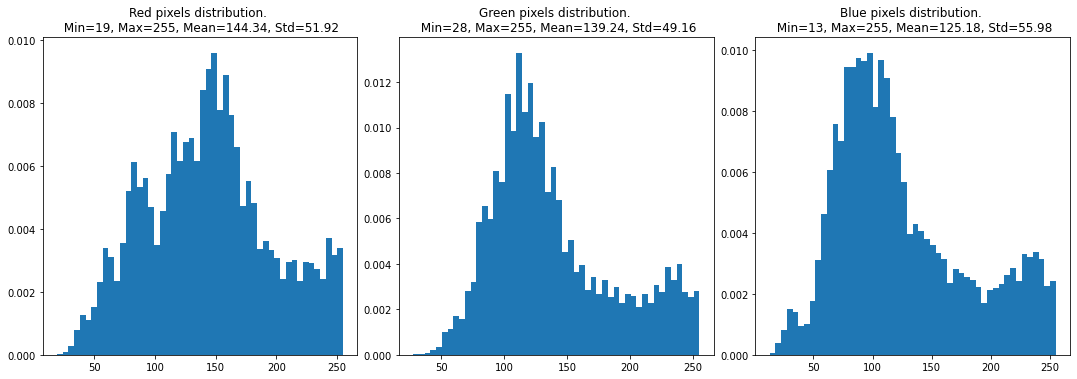

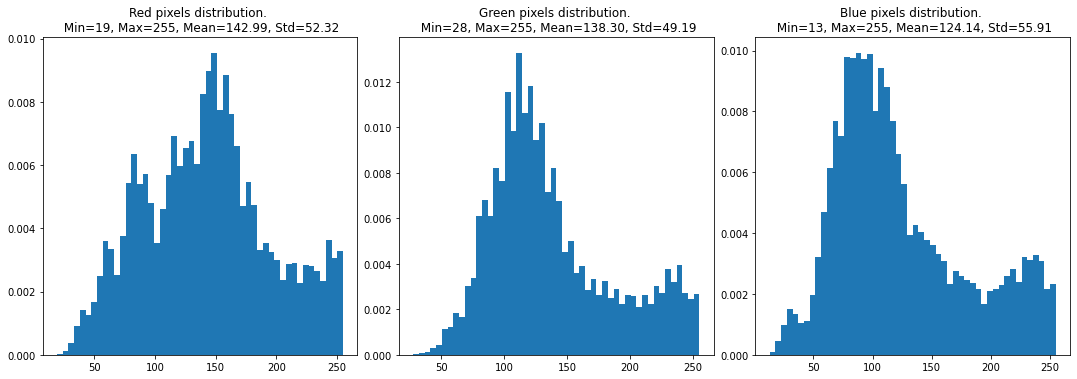

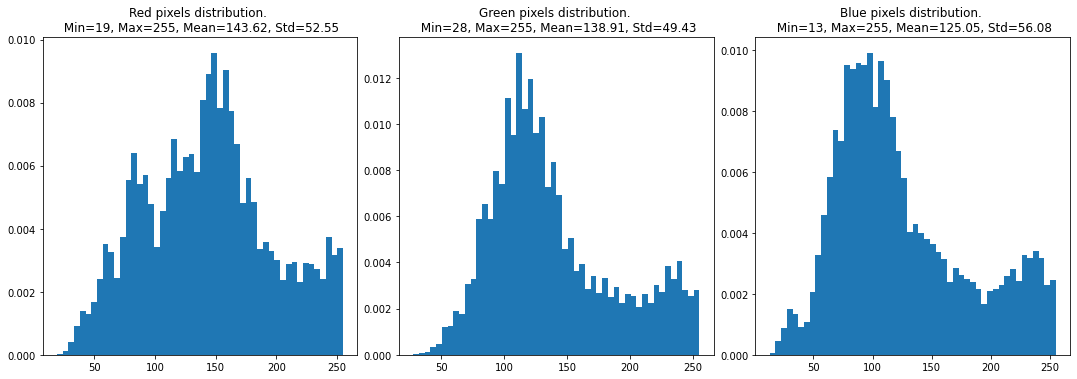

In [10]:
print("Summary for Training dataset")
show_dataset_summary(training_dataset)

print("Summary for Unlabelled dataset")
show_dataset_summary(unlabelled_dataset)

print("Summary for Validation dataset")
show_dataset_summary(val_dataset)

Distribution of channel pixels among the datasets are nearly same. That is good thing

# Action points
Based on the above analysis, you can normalize your images for better performance with the below code snipped. For example the below normalization is given for training set.  
**NOTE:** *Don't get confused between the numbers shown in mean, std in graphs above and the numbers below. `ToTensor` normalize the image pixels by dividing each pixel with 255 and therefore you need to put the normalized means and standard deviations in `torchvision.transforms.Normalize`*

```
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.566, 0.546, 0.490],
        std=[0.204, 0.193, 0.219],
    ),
])
```